In [1]:
%reload_ext autoreload

In [2]:
%autoreload
import pandas as pd
import numpy as np
from mvlearn.embed import MCCA
import umap

from sklearn.decomposition import PCA

from IPython.display import clear_output

import sys
sys.path.append("..")

from src.mofa_utils import train_mofa
from src.tcga_preprocess_utils import split_patients_for_target_prediction
from src.constants import RANDOM_STATE, CANCER_SUBTYPE_FEATURE
from src.pipelines import subtype_classification_pipeline
from src.autoencoder import EncoderPipeline

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0" 

2024-03-24 16:46:20.951809: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-24 16:46:20.985243: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-24 16:46:20.985279: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-24 16:46:20.986076: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-24 16:46:20.991838: I tensorflow/core/platform/cpu_feature_guar

Загружаем обработанные данные по раку груди, выживаемости и клинические данные. Всего после предобработки - 620 пациентов. Делаем разделение на трейн и тест, в которые попадают одни и те же пациенты - для каждой модели.

In [3]:
dna_breast = pd.read_csv('data/breast/expression_data_breast_for_subtype_pred.csv', index_col=[0])

rna_breast = pd.read_csv('data/breast/mirna_data_breast_for_subtype_pred.csv', index_col=[0])

methylation_breast = pd.read_csv('data/breast/methylation_data_breast_for_subtype_pred.csv', index_col=[0])

mofa_data_breast = pd.read_csv('data/breast/mofa_data_breast_for_subtype_pred.csv')
clinical_data_breast = pd.read_csv('data/breast/clinical_data_breast_for_subtype_pred.csv')


cancer_subtype = pd.DataFrame(clinical_data_breast[CANCER_SUBTYPE_FEATURE])

In [4]:
N_FACTORS = 20
TRAIN_INDICES, TEST_INDICES = split_patients_for_target_prediction(cancer_subtype, stratify_by=CANCER_SUBTYPE_FEATURE)

Из клинических данных вручную отобраны фичи, которые не связаны с таргетом, содержат более 80% непустых данных и более 1 уникального значения, и которые не являются техническими (названия файлов, идентификаторы и прочее)

In [5]:
CATEGORICAL_CLINICAL_FEATURES = [
                                 'anatomic_neoplasm_subdivision', 
                                 'axillary_lymph_node_stage_method_type',
                                 'breast_carcinoma_estrogen_receptor_status',
                                 'breast_carcinoma_progesterone_receptor_status',
                                 'breast_carcinoma_surgical_procedure_name',
                                 'gender',
                                 'history_of_neoadjuvant_treatment',
                                 'icd_10',
                                 'icd_o_3_site',
                                 'initial_pathologic_diagnosis_method',
                                 'lab_proc_her2_neu_immunohistochemistry_receptor_status',
                                 'margin_status',
                                 'menopause_status',
                                 'new_tumor_event_after_initial_treatment',
                                 'oct_embedded',
                                 'pathologic_M',
                                 'pathologic_N',
                                 'pathologic_T',
                                 'pathologic_stage',
                                 'person_neoplasm_cancer_status',
                                 'primary_lymph_node_presentation_assessment',
                                 'radiation_therapy',
                                 'system_version',
                                 'tissue_prospective_collection_indicator',
                                 'tissue_retrospective_collection_indicator',
                                 'tissue_source_site']
NUMERICAL_CLINICAL_FEATURES = ['age_at_initial_pathologic_diagnosis',
                               'initial_weight', 'lymph_node_examined_count', 'number_of_lymphnodes_positive_by_he']
N_CATEGORICAL_CLINICAL = len(CATEGORICAL_CLINICAL_FEATURES)
N_NUMERIC_CLINICAL = len(NUMERICAL_CLINICAL_FEATURES)

In [6]:
clinical_features = clinical_data_breast[NUMERICAL_CLINICAL_FEATURES + CATEGORICAL_CLINICAL_FEATURES]

for col in CATEGORICAL_CLINICAL_FEATURES:
    clinical_features[col] = clinical_features[col].fillna('missing')

clinical_features.head()

,age_at_initial_pathologic_diagnosis,initial_weight,lymph_node_examined_count,number_of_lymphnodes_positive_by_he,anatomic_neoplasm_subdivision,axillary_lymph_node_stage_method_type,breast_carcinoma_estrogen_receptor_status,breast_carcinoma_progesterone_receptor_status,breast_carcinoma_surgical_procedure_name,gender,...,pathologic_N,pathologic_T,pathologic_stage,person_neoplasm_cancer_status,primary_lymph_node_presentation_assessment,radiation_therapy,system_version,tissue_prospective_collection_indicator,tissue_retrospective_collection_indicator,tissue_source_site
0,55.0,60.0,13.0,4.0,Left Lower Outer Quadrant,Sentinel lymph node biopsy plus axillary disse...,Positive,Positive,Modified Radical Mastectomy,FEMALE,...,NX,TX,Stage X,WITH TUMOR,YES,NO,6th,NO,YES,3C
1,50.0,120.0,15.0,1.0,Right Upper Outer Quadrant,Sentinel lymph node biopsy plus axillary disse...,Positive,Positive,Lumpectomy,FEMALE,...,N1a,T2,Stage IIB,TUMOR FREE,YES,YES,6th,NO,YES,3C
2,62.0,NaN,23.0,1.0,Right,missing,Positive,Positive,Modified Radical Mastectomy,FEMALE,...,N1a,T2,Stage IIB,TUMOR FREE,YES,NO,7th,NO,YES,3C
3,52.0,140.0,2.0,0.0,Right,Sentinel node biopsy alone,Positive,Positive,Simple Mastectomy,FEMALE,...,N0 (i+),T1c,Stage IA,TUMOR FREE,YES,NO,7th,NO,YES,3C
4,50.0,770.0,14.0,4.0,Left|Left Upper Outer Quadrant,Axillary lymph node dissection alone,Positive,Positive,Modified Radical Mastectomy,FEMALE,...,N2a,T2,Stage IIIA,TUMOR FREE,YES,NO,7th,YES,NO,4H


### Обучаем модели факторизации

MOFA

In [7]:
mofa_factors, weights, r2 = train_mofa(mofa_data_breast.copy(), RANDOM_STATE, factors=N_FACTORS)
clear_output()

MCCA

In [8]:
cca = MCCA(n_components=N_FACTORS, regs='oas', multiview_output=False)
mcca_factors = cca.fit_transform([dna_breast.values, rna_breast.values, methylation_breast.values])

PCA

In [9]:
X_breast_all = np.hstack([dna_breast.values, rna_breast.values, methylation_breast.values])

In [10]:
pca = PCA(n_components=N_FACTORS)
pca_factors = pca.fit_transform(X_breast_all)

UMAP

In [11]:
reducer = umap.UMAP(n_components=N_FACTORS, random_state=RANDOM_STATE)
umap_factors = reducer.fit_transform(X_breast_all)

Base Autoencoder - модель из статьи Deep Learning–Based Multi-Omics Integration Robustly Predicts Survival in Liver Cancer: 1 энкодер для всех 3х модальностей, сконкатенированных друг с другом, 1 скрытый линейный слой, ф-ция активации - tanh, dropout 0.5

In [12]:
%autoreload
base_enc_pipeline = EncoderPipeline([dna_breast.values, rna_breast.values, methylation_breast.values], N_FACTORS, RANDOM_STATE, base=True)
base_enc_pipeline.train()

clear_output()
base_autoenc_factors = base_enc_pipeline.encode()

Triple Autoencoder - дополненная мною архитектура: 3 отдельных экодера для каждой модельности, т.е. веса сначала подстраиваются под специфику модальности, и только затем объединяются. 2 скрытых линейный слоя, ф-ция активации ReLU (менее подвержена затухающему градиенту), батч-нормализация

In [13]:
%autoreload
triple_enc_pipeline = EncoderPipeline([dna_breast.values, rna_breast.values, methylation_breast.values], N_FACTORS, RANDOM_STATE)
triple_enc_pipeline.train()

clear_output()
triple_autoenc_factors = triple_enc_pipeline.encode()

In [14]:
pipeline_base_args = [clinical_features, cancer_subtype, TRAIN_INDICES, TEST_INDICES, RANDOM_STATE,
                       X_breast_all.shape[1], N_NUMERIC_CLINICAL, NUMERICAL_CLINICAL_FEATURES + CATEGORICAL_CLINICAL_FEATURES]

pipeline_args = [clinical_features, cancer_subtype, TRAIN_INDICES, TEST_INDICES, RANDOM_STATE,
                       N_FACTORS, N_NUMERIC_CLINICAL, NUMERICAL_CLINICAL_FEATURES + CATEGORICAL_CLINICAL_FEATURES]

## Классификация: предсказание гистологического типа рака груди

### Бейзлайн: без факторизации

In [15]:
%autoreload
r_f_base, r_c_base = subtype_classification_pipeline(X_breast_all, *pipeline_base_args, plot_feat_imp=False)

### MOFA

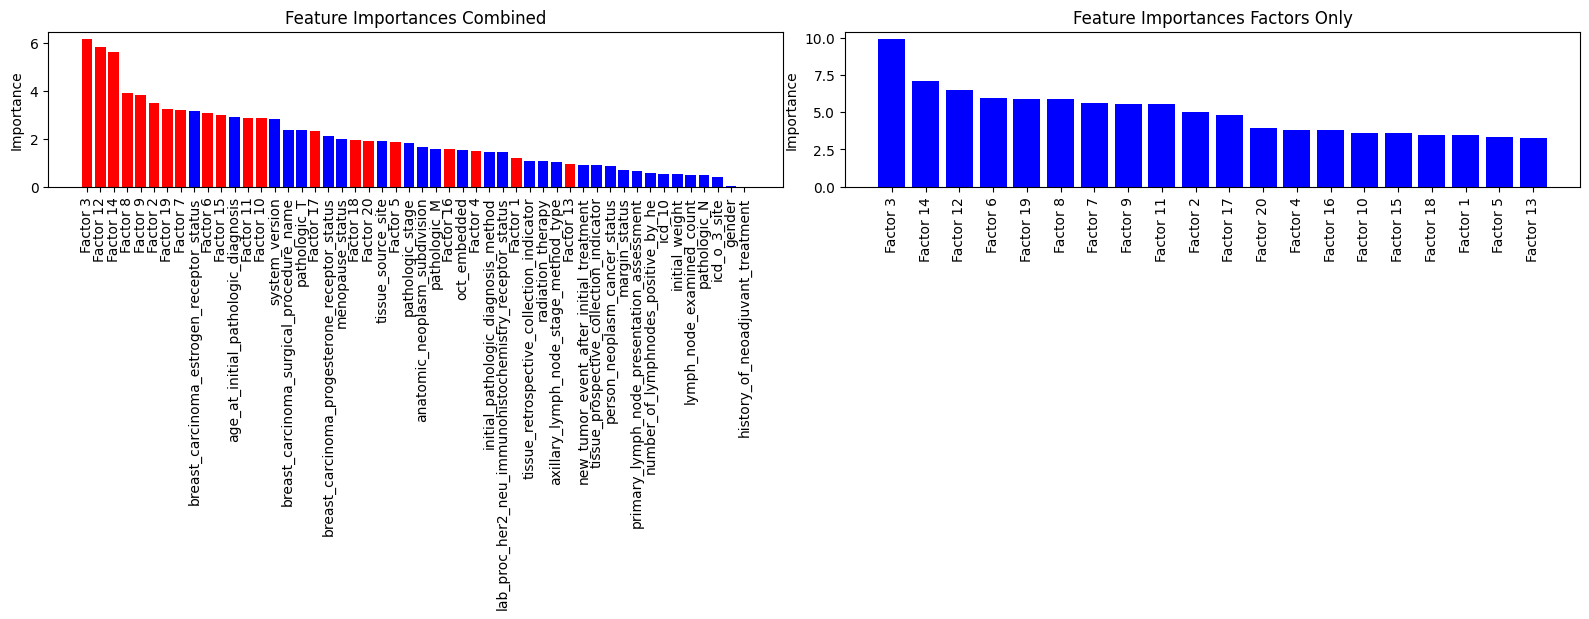

In [16]:
%autoreload
r_f_mofa, r_c_mofa, f_f_mofa, f_c_mofa = subtype_classification_pipeline(mofa_factors, *pipeline_args)

### MCCA

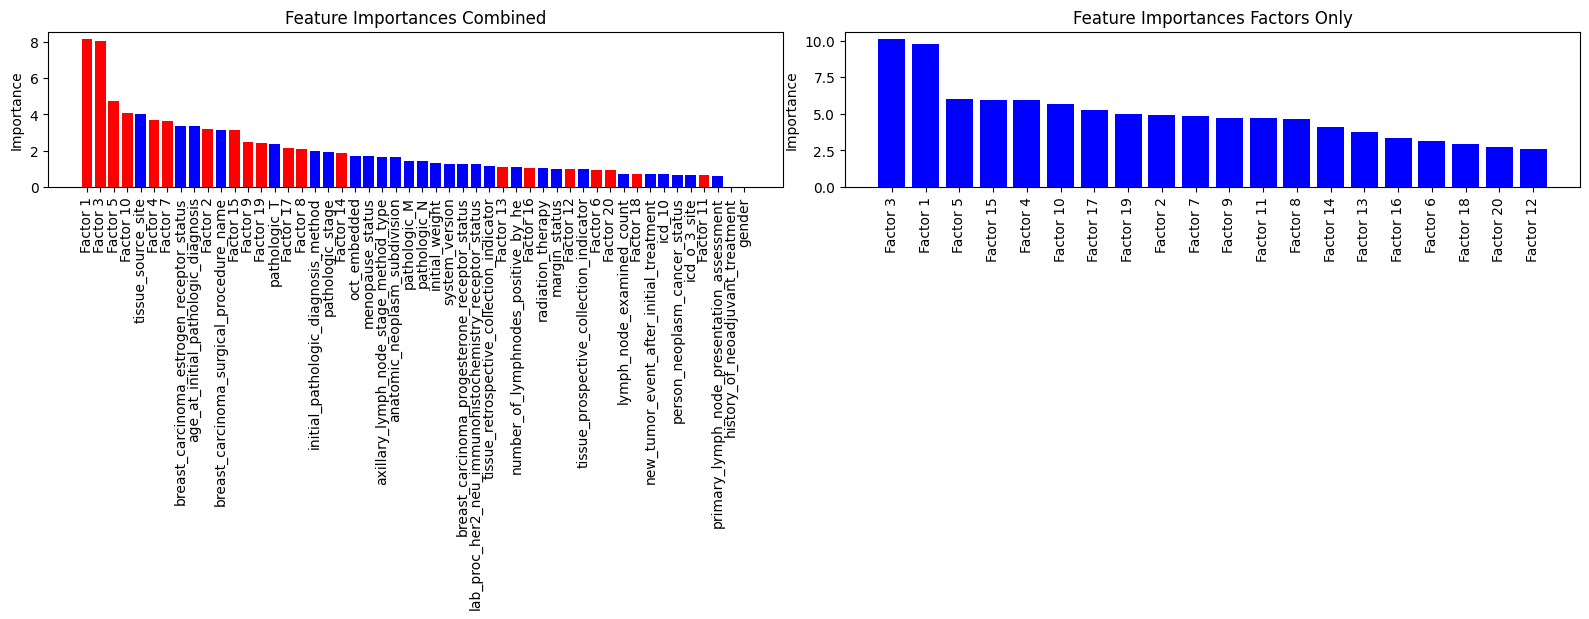

In [17]:
r_f_mcca, r_c_mcca, f_f_mcca, f_c_mcca = subtype_classification_pipeline(mcca_factors, *pipeline_args)

### PCA

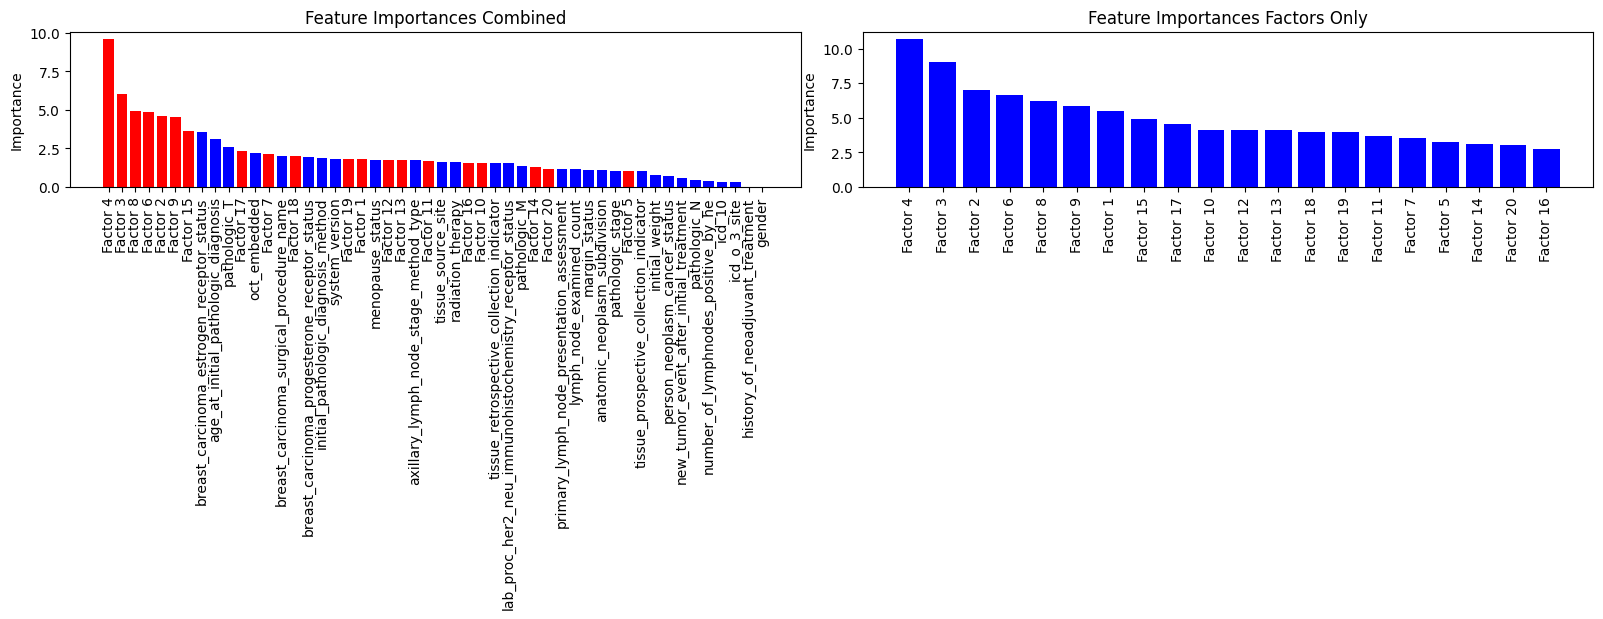

In [18]:
r_f_pca, r_c_pca, f_f_pca, f_c_pca = subtype_classification_pipeline(pca_factors, *pipeline_args)

### UMAP

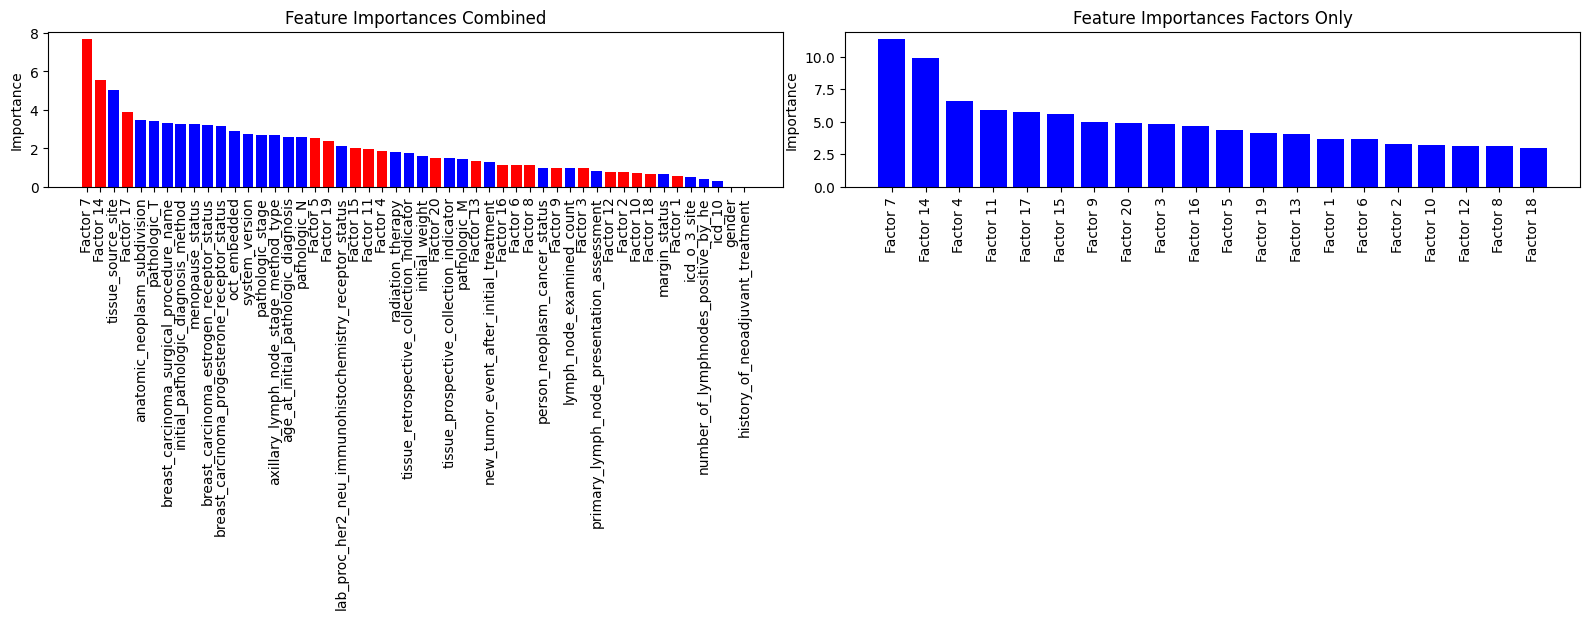

In [19]:
r_f_umap, r_c_umap, f_f_umap, f_c_umap = subtype_classification_pipeline(umap_factors, *pipeline_args)

### Base Autoencoder

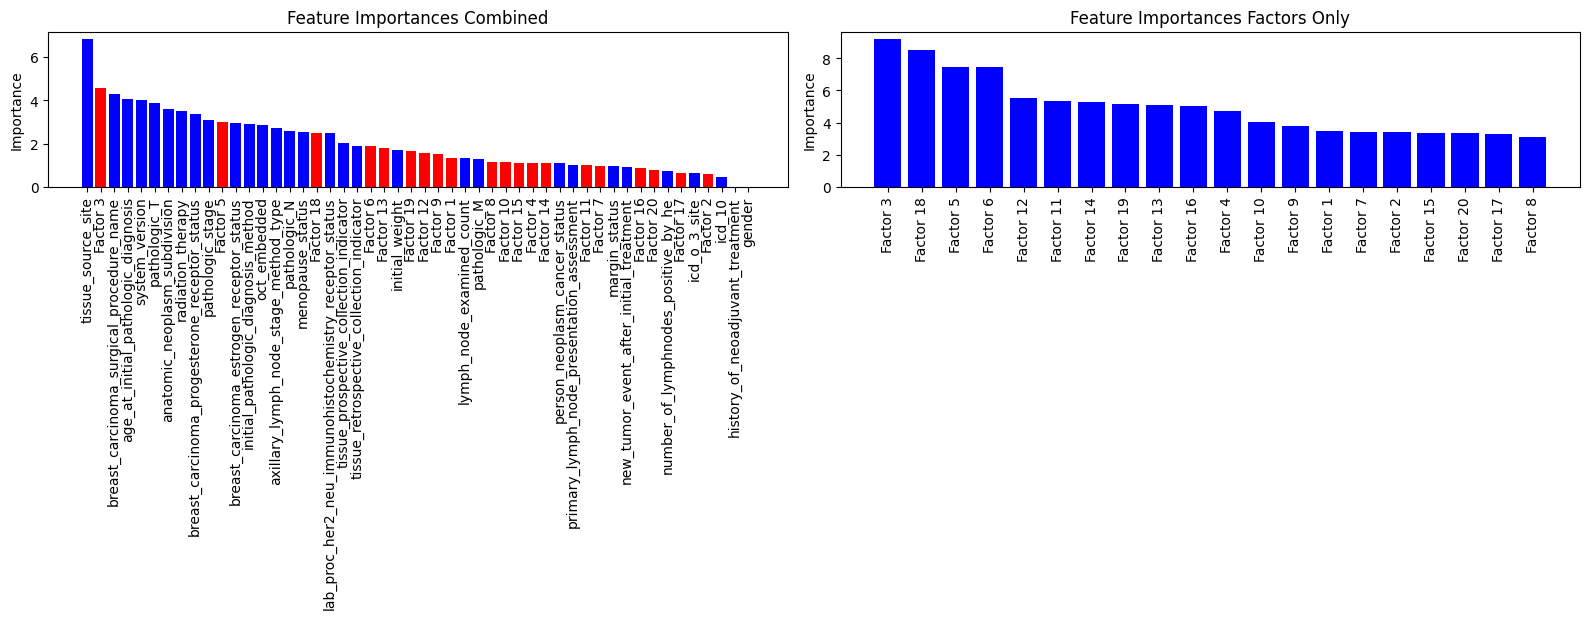

In [20]:
%autoreload
r_f_base_auto, r_c_base_auto, f_f_triple_auto, f_c_base_auto = subtype_classification_pipeline(base_autoenc_factors, *pipeline_args)

### Triple Autoencoder

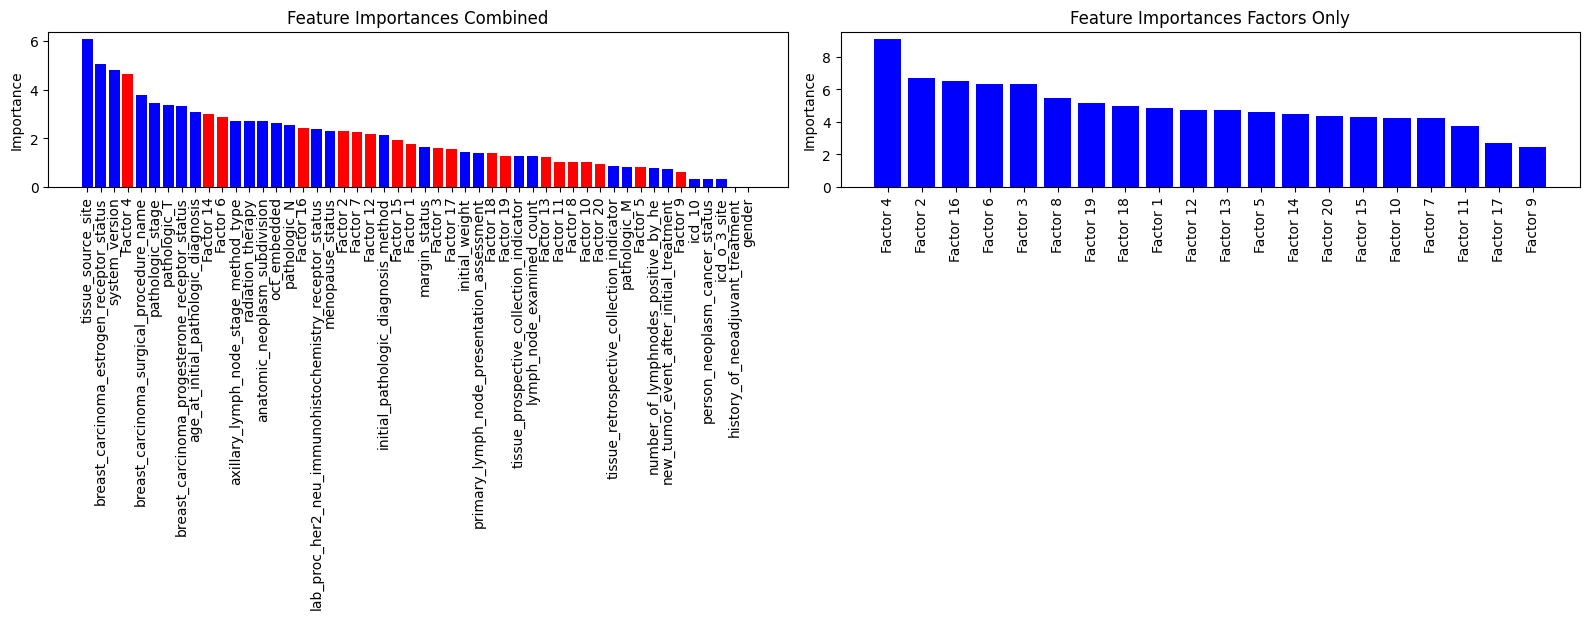

In [21]:
r_f_triple_auto, r_c_triple_auto, f_f_triple_auto, f_c_triple_auto = subtype_classification_pipeline(triple_autoenc_factors, *pipeline_args)

### Классификация, результаты:

In [22]:
def subtype_classification_results(classification_reports, method_names = ['No factorization', 'PCA', 'UMAP', 'MOFA', 'MCCA', 'Base Autoencoder', 'Triple Autoencoder']):
    data_for_df = []

    for report, method in zip(classification_reports, method_names):
        method_metrics = {'Method': method}
        
        for key, value in report.items():
            if key in ['macro avg', 'weighted avg']:
                method_metrics[f"{key} f1-score"] = value.get('f1-score', value)
            elif key == 'accuracy':
                pass
            else:
                method_metrics[f"{key} f1-score"] = value['f1-score']
        data_for_df.append(method_metrics)

    df = pd.DataFrame(data_for_df)
    df.set_index('Method', inplace=True)
    return df

In [23]:
factors_results = subtype_classification_results([r_f_base, r_f_pca, r_f_umap, r_f_mofa, r_f_mcca, r_f_base_auto, r_f_triple_auto])
factors_results.to_csv('data/subtype-classification-res-with-factors.csv')

factors_results

,Infiltrating Ductal Carcinoma f1-score,Infiltrating Lobular Carcinoma f1-score,Metaplastic Carcinoma f1-score,Mixed Histology (please specify) f1-score,Mucinous Carcinoma f1-score,"Other, specify f1-score",macro avg f1-score,weighted avg f1-score
Method,,,,,,,,
No factorization,0.834081,0.656716,0.0,0.0,0.400000,0.0,0.315133,0.705176
PCA,0.831776,0.720000,0.0,0.0,0.333333,0.0,0.314185,0.718856
UMAP,0.764151,0.467532,0.0,0.0,0.000000,0.0,0.205281,0.600827
MOFA,0.822430,0.594595,0.0,0.0,0.333333,0.0,0.291726,0.679643
MCCA,0.792453,0.575342,0.0,0.0,0.400000,0.0,0.294633,0.657562
Base Autoencoder,0.781395,0.533333,0.0,0.0,0.000000,0.0,0.219121,0.629095
Triple Autoencoder,0.777778,0.533333,0.0,0.0,0.000000,0.0,0.218519,0.626840


In [24]:
combined_results = subtype_classification_results([r_c_base, r_c_pca, r_c_umap, r_c_mofa, r_c_mcca, r_c_base_auto, r_c_triple_auto])
combined_results.to_csv('data/subtype-classification-res-with-factors-and-clinical.csv')

combined_results

,Infiltrating Ductal Carcinoma f1-score,Infiltrating Lobular Carcinoma f1-score,Metaplastic Carcinoma f1-score,Mixed Histology (please specify) f1-score,Mucinous Carcinoma f1-score,"Other, specify f1-score",macro avg f1-score,weighted avg f1-score
Method,,,,,,,,
No factorization,0.840183,0.704225,0.0,0.0,0.400000,0.0,0.324068,0.721628
PCA,0.842593,0.729730,0.0,0.0,0.400000,0.0,0.328720,0.729921
UMAP,0.759615,0.487805,0.0,0.0,0.400000,0.0,0.274570,0.613786
MOFA,0.820755,0.675325,0.0,0.0,0.400000,0.0,0.316013,0.701823
MCCA,0.805687,0.615385,0.0,0.0,0.666667,0.0,0.347956,0.683399
Base Autoencoder,0.792627,0.621622,0.0,0.0,0.000000,0.0,0.235708,0.659602
Triple Autoencoder,0.790476,0.617284,0.0,0.0,0.000000,0.0,0.234627,0.657106


### *В задаче предсказания гистологического типа по факторам лучше всего оказался PCA*

P.S откуда брались данные - из той же ткани или нет?